# Mini-batch [Continuation]

```text
- Variation of gradient descent that splits the training data into smalleer batches that are used for calculating the model error and updating the model weights.
- Batch size is often powers of 2. e.g. between 2 to 512.
- Training in batches can reduce the computational time because of vectorization (matrix multiplication instead of for-loops).
- It smoothens learning by averaging the loss over many samples thereby reducing overfitting.
```

In [1]:
# Built-in library
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import numpy.typing as npt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Configure the backend
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

# Custom import
from src.utilities import create_iris_data, smooth, load_data
from src.preprocessor import Standardizer


# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
fp = "../../data/wine_data.csv"

data = load_data(filename=fp)
data.head()

Shape of data: (1599, 12)



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
# Display the number of unique labels per feature
for var in data.columns:
    n_uniq = data[var].nunique()
    print(f"{var}: {n_uniq} labels\n")

fixed acidity: 96 labels

volatile acidity: 143 labels

citric acid: 80 labels

residual sugar: 91 labels

chlorides: 153 labels

free sulfur dioxide: 60 labels

total sulfur dioxide: 144 labels

density: 436 labels

pH: 89 labels

sulphates: 96 labels

alcohol: 65 labels

quality: 6 labels



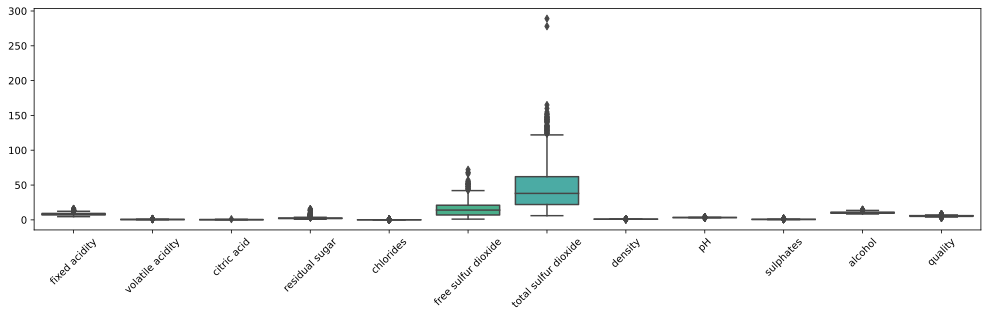

In [4]:
# Boxplot of the data
fig, ax = plt.subplots(1, figsize=(17, 4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [5]:
# Standardize the data
data.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [6]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [7]:
stand_ = Standardizer()
data_standardized = stand_.fit_transform(X=data.iloc[:, :-1])

data_standardized.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03
mean,3.554936e-16,1.733031e-16,-8.887339e-17,-1.244227e-16,3.732682e-16,-6.221137e-17,4.443669e-17,-3.473172e-14,2.861723e-15,6.754377e-16,1.066481e-16
std,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00
min,-2.137045e+00,-2.278280e+00,-1.391472e+00,-1.162696e+00,-1.603945e+00,-1.422500e+00,-1.230584e+00,-3.538731e+00,-3.700401e+00,-1.936507e+00,-1.898919e+00
25%,-7.007187e-01,-7.699311e-01,-9.293181e-01,-4.532184e-01,-3.712290e-01,-8.487156e-01,-7.440403e-01,-6.077557e-01,-6.551405e-01,-6.382196e-01,-8.663789e-01
50%,-2.410944e-01,-4.368911e-02,-5.636026e-02,-2.403750e-01,-1.799455e-01,-1.793002e-01,-2.574968e-01,1.760083e-03,-7.212705e-03,-2.251281e-01,-2.093081e-01
75%,5.057952e-01,6.266881e-01,7.652471e-01,4.341614e-02,5.384542e-02,4.901152e-01,4.723184e-01,5.768249e-01,5.759223e-01,4.240158e-01,6.354971e-01
max,4.355149e+00,5.877976e+00,3.743574e+00,9.195681e+00,1.112703e+01,5.367284e+00,7.375154e+00,3.680055e+00,4.528282e+00,7.918677e+00,4.202453e+00


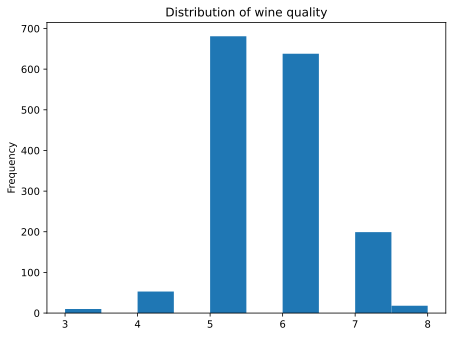

In [8]:
# Distribution of the target
data["quality"].plot(kind="hist", title="Distribution of wine quality")
plt.tight_layout()
plt.show()

#### Observation(s)

```text
- The data is imbalenced.
- I'll binarize the target variable.
```

In [9]:
choice_list = [0, 1]

# 3, 4, and 5 : 0, else 1
data["target"] = np.where(
    data["quality"].isin(np.arange(3, 6)), choice_list[0], choice_list[1]
)

data[["quality", "target"]].sample(10, random_state=5)

,quality,target
236,6,1
833,4,0
424,5,0
982,6,1
1155,5,0
412,5,0
419,5,0
1098,7,1
1414,5,0
994,5,0


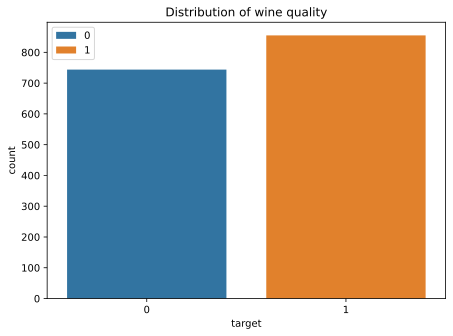

In [10]:
# Distribution of the target
sns.countplot(x="target", data=data, hue="target", dodge=False)
plt.title("Distribution of wine quality")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

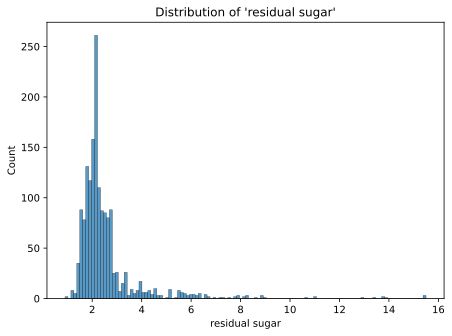

In [11]:
x = "residual sugar"
sns.histplot(x=x, data=data)
plt.title(f"Distribution of {x!r}")
plt.tight_layout()
plt.show()

In [12]:
# Convert to Tensors
X = torch.Tensor(data_standardized.to_numpy())
# Requred by PyTorch to be 2D instead of 1D
y = torch.Tensor(data["target"].to_numpy()).reshape(-1, 1)

# Split data
TEST_SIZE, RANDOM_STATE = 0.2, 123
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_validation.shape

(torch.Size([1279, 11]), torch.Size([320, 11]))

In [13]:
batch_size = 16

# Create Tensor Dataset
train_data = TensorDataset(X_train, y_train)
validation_data = TensorDataset(X_validation, y_validation)


# Create Tensor Dataloader
train_DL = DataLoader(
    dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True
)
validation_DL = DataLoader(
    dataset=validation_data, batch_size=validation_data.tensors[0].shape[0]
)

In [14]:
data_standardized.shape

(1599, 11)

In [15]:
class Net(nn.Module):
    """This is the DL model architecture for classifying
    wines into good or bad."""

    def __init__(self, *, n_units: int) -> None:
        super().__init__()
        self.input = nn.Linear(11, n_units)
        self.hidden = nn.Linear(n_units, n_units)
        self.output = nn.Linear(n_units, 1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used to perform forward propagation."""
        X = F.relu(self.input(X))
        X = F.relu(self.hidden(X))
        X = F.sigmoid(self.output(X))
        return X


def train_model(*, train_data_loader: DataLoader, validation_data_loader: DataLoader):
    """This is used to train the ANN model."""
    net = Net(n_units=64)
    learning_rate, epochs = 0.01, 1_000
    THRESH, PCT = 0.5, 100
    optimizer = torch.optim.SGD(params=net.parameters(), lr=learning_rate)
    criterion, losses = nn.BCELoss(), []
    train_accuracy, validation_accuracy = [], []

    # Iterate over the epochs
    for epoch_idx in np.arange(epochs):
        batch_acc, train_losses = [], []
        net.train()

        # Iterate over the batches
        for X_, y_ in train_data_loader:
            # Reset the gradients
            optimizer.zero_grad()

            # Forward prop and loss
            y_proba_ = net(X_)
            loss = criterion(y_proba_, y_)
            train_losses.append(loss.detach())

            # Back prop
            loss.backward()
            optimizer.step()

            # Compute batch metrics
            acc_ = torch.mean(((y_proba_ > THRESH) == y_).float()) * PCT
            batch_acc.append(acc_.detach())

        # Training
        train_accuracy.append(np.mean(batch_acc))
        losses.append(np.mean(train_losses))

        # Validation
        net.eval()
        X_val, y_val = next(iter(validation_data_loader))
        y_proba_val = net(X_val)
        val_acc = torch.mean(((y_proba_val > THRESH) == y_val).float()) * PCT
        validation_accuracy.append(val_acc)

    return train_accuracy, validation_accuracy, losses

In [16]:
train_accuracy, validation_accuracy, losses = train_model(
    train_data_loader=train_DL, validation_data_loader=validation_DL
)

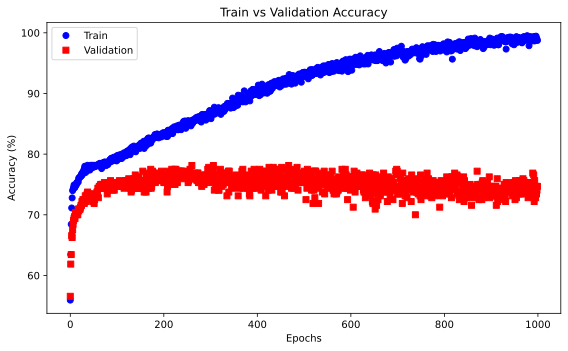

In [17]:
_, ax = plt.subplots(figsize=(8, 5))

ax.plot(train_accuracy, "bo")
ax.plot(validation_accuracy, "rs")
ax.set(xlabel="Epochs", ylabel="Accuracy (%)", title="Train vs Validation Accuracy")

plt.legend(["Train", "Validation"])
plt.tight_layout()
plt.show()

### Parametric Experiment

```text
- Experiment with different batch sizes.
- Record the time taken to train the model using different batch sizes.
```

In [22]:
import time


# Create Tensor Dataloader
validation_DL = DataLoader(
    dataset=validation_data, batch_size=validation_data.tensors[0].shape[0]
)

batch_sizes, epochs = np.power(2, np.arange(1, 10)), 1_000


train_accuracy, validation_accuracy = (
    np.zeros(shape=(epochs, batch_sizes.shape[0])),
    np.zeros(shape=(epochs, batch_sizes.shape[0])),
)
comp_time = np.zeros(batch_sizes.shape[0])

for idx, b_size in enumerate(batch_sizes):
    start_time = time.process_time()

    train_DL = DataLoader(
        dataset=train_data, batch_size=int(b_size), shuffle=True, drop_last=True
    )
    train_acc, validation_acc, _ = train_model(
        train_data_loader=train_DL, validation_data_loader=validation_DL
    )
    train_accuracy[:, idx] = train_acc
    validation_accuracy[:, idx] = validation_acc

    # Check the timer
    comp_time[idx] = time.process_time() - start_time

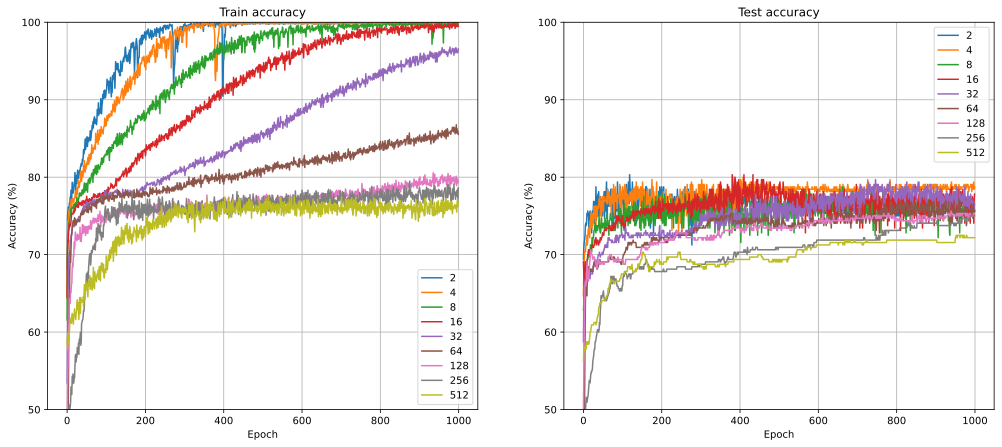

In [23]:
# Visualize the results
fig, ax = plt.subplots(1, 2, figsize=(17, 7))

ax[0].plot(train_accuracy)
ax[0].set_title("Train accuracy")
ax[1].plot(validation_accuracy)
ax[1].set_title("Test accuracy")

# common features
for i in range(2):
    ax[i].legend(batch_sizes)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracy (%)")
    ax[i].set_ylim([50, 100])
    ax[i].grid()

plt.show()

#### Observation(s)

```text
- The model is overfitting when a batch size of <= 64 was used. This is highlighted by the validation accuracy.
- The model with batch size of 128 seems to be the best performing model.
- The validation accuracy is less than 80%.
```

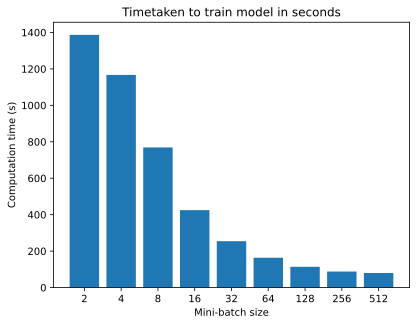

In [25]:
# Bar plot of computation time
plt.bar(range(len(comp_time)), comp_time, tick_label=batch_sizes)
plt.xlabel("Mini-batch size")
plt.ylabel("Computation time (s)")
plt.title("Timetaken to train model in seconds")
plt.show()

#### Observation(s)

```text
- Models with small batch size take much longer to train compared with models with large batch size.
```